In [1]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트 설정 (Matplotlib에서 한글 깨짐 방지)
import matplotlib.pyplot as plt

plt.rc("font", family="NanumGothic")  # Windows 사용자의 경우

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

# 기본 라이브러리
import polars as pl
import pandas as pd
import seaborn as sns
import numpy as np

# 시각화용 색상 팔레트
color_palette = sns.color_palette("Set2", as_cmap=False)

In [2]:
cluster_a_pd = pl.read_csv('data/cluster_a_pd.csv')

In [3]:
cluster_b_pd = pl.read_csv('data/cluster_b_pd.csv')

In [4]:
cluster_c_pd = pl.read_csv('data/cluster_c_pd.csv')

In [5]:
cluster_d_pd = pl.read_csv('data/cluster_d_pd.csv')

In [8]:

상품_컬럼 = [
    "수신_요구불예금", "수신_거치식예금", "수신_적립식예금",
    "수신_펀드", "수신_외화예금", "대출금액", "카드_사용여부"
]



In [16]:
# 4. 상품조합 생성
def create_product_combination_polars_from_pandas(pandas_df: pd.DataFrame, product_cols, chunk_size: int = 200000):
    import pandas as pd
    import polars as pl
    from tqdm import tqdm
    import time

    start_time = time.time()
    
    # 1. pandas → polars 변환
    status_cols = [col + "_상태" for col in product_cols]
    
    total_rows = pandas_df.height
    total_chunks = (total_rows - 1) // chunk_size + 1
    print(f"전체 행 수: {total_rows} | 청크 크기: {chunk_size} → 총 {total_chunks}개 청크")

    # 2. 청크 단위로 처리하며 진행률 표시
    chunks = []
    for i in tqdm(range(0, total_rows, chunk_size), desc="상품조합 생성 중"):
        chunk = pandas_df.slice(i, chunk_size)
        chunk = chunk.with_columns([
            pl.concat_str([pl.col(col) for col in status_cols], separator="_").alias("상품조합")
        ])
        chunks.append(chunk)

    # 3. 청크 합치기
    result = pl.concat(chunks)
    
    elapsed_time = time.time() - start_time
    print(f"[상품조합 생성 완료] 총 처리 시간: {elapsed_time:.2f}초")

    return result  # ✅ Polars DataFrame 리턴


In [17]:
cluster_a_pl = create_product_combination_polars_from_pandas(cluster_a_pd, 상품_컬럼, chunk_size=100000)

전체 행 수: 817124 | 청크 크기: 100000 → 총 9개 청크


상품조합 생성 중: 100%|██████████| 9/9 [00:00<00:00, 131.86it/s]

[상품조합 생성 완료] 총 처리 시간: 0.07초


In [18]:
cluster_b_pl = create_product_combination_polars_from_pandas(cluster_b_pd, 상품_컬럼, chunk_size=10000)

전체 행 수: 14790124 | 청크 크기: 10000 → 총 1480개 청크


상품조합 생성 중: 100%|██████████| 1480/1480 [00:02<00:00, 689.07it/s]

[상품조합 생성 완료] 총 처리 시간: 2.16초


In [19]:
cluster_c_pl = create_product_combination_polars_from_pandas(cluster_c_pd, 상품_컬럼, chunk_size=10000)

전체 행 수: 2482677 | 청크 크기: 10000 → 총 249개 청크


상품조합 생성 중: 100%|██████████| 249/249 [00:00<00:00, 750.37it/s]

[상품조합 생성 완료] 총 처리 시간: 0.34초


In [20]:
cluster_d_pl = create_product_combination_polars_from_pandas(cluster_d_pd, 상품_컬럼, chunk_size=10000)

전체 행 수: 284027 | 청크 크기: 10000 → 총 29개 청크


상품조합 생성 중: 100%|██████████| 29/29 [00:00<00:00, 759.28it/s]

[상품조합 생성 완료] 총 처리 시간: 0.04초


In [21]:
cluster_a_pl.head()

,고객ID,수신_요구불예금,수신_거치식예금,수신_적립식예금,수신_펀드,수신_외화예금,대출금액,카드_사용여부,중분류,수신_요구불예금_상태,수신_거치식예금_상태,수신_적립식예금_상태,수신_펀드_상태,수신_외화예금_상태,대출금액_상태,카드_사용여부_상태,상품조합
i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str
0,6051244903,1,0,0,0,0,1,1,"""A: 저활동 그룹(클러스터 1,5)""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O""","""수신_요구불예금-O_수신_거치식예금-X_수신_적립식예금…"
1,6051244903,1,0,0,0,0,1,1,"""A: 저활동 그룹(클러스터 1,5)""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O""","""수신_요구불예금-O_수신_거치식예금-X_수신_적립식예금…"
2,6051244903,1,0,0,0,0,1,1,"""A: 저활동 그룹(클러스터 1,5)""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O""","""수신_요구불예금-O_수신_거치식예금-X_수신_적립식예금…"
3,6051244903,1,0,0,0,0,1,1,"""A: 저활동 그룹(클러스터 1,5)""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O""","""수신_요구불예금-O_수신_거치식예금-X_수신_적립식예금…"
4,6051244903,1,0,0,0,0,1,1,"""A: 저활동 그룹(클러스터 1,5)""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O""","""수신_요구불예금-O_수신_거치식예금-X_수신_적립식예금…"


In [22]:
# 6. 조합별 고객 수 확인
combo_summary_cluster_a = (cluster_a_pl.group_by("상품조합").count().rename({"count": "고객수"}).sort("고객수", descending=True))
combo_summary_cluster_b = (cluster_b_pl.group_by("상품조합").count().rename({"count": "고객수"}).sort("고객수", descending=True))
combo_summary_cluster_c = (cluster_c_pl.group_by("상품조합").count().rename({"count": "고객수"}).sort("고객수", descending=True))
combo_summary_cluster_d = (cluster_d_pl.group_by("상품조합").count().rename({"count": "고객수"}).sort("고객수", descending=True))

In [23]:
combo_summary_cluster_a.head(10)

상품조합,고객수
str,u32
"""수신_요구불예금-O_수신_거치식예금-X_수신_적립식예금…",288619
"""수신_요구불예금-O_수신_거치식예금-X_수신_적립식예금…",214244
"""수신_요구불예금-O_수신_거치식예금-X_수신_적립식예금…",132494
"""수신_요구불예금-X_수신_거치식예금-X_수신_적립식예금…",84087
"""수신_요구불예금-O_수신_거치식예금-X_수신_적립식예금…",31614
"""수신_요구불예금-O_수신_거치식예금-O_수신_적립식예금…",22989
"""수신_요구불예금-O_수신_거치식예금-X_수신_적립식예금…",6397
"""수신_요구불예금-O_수신_거치식예금-O_수신_적립식예금…",5059
"""수신_요구불예금-O_수신_거치식예금-O_수신_적립식예금…",3935


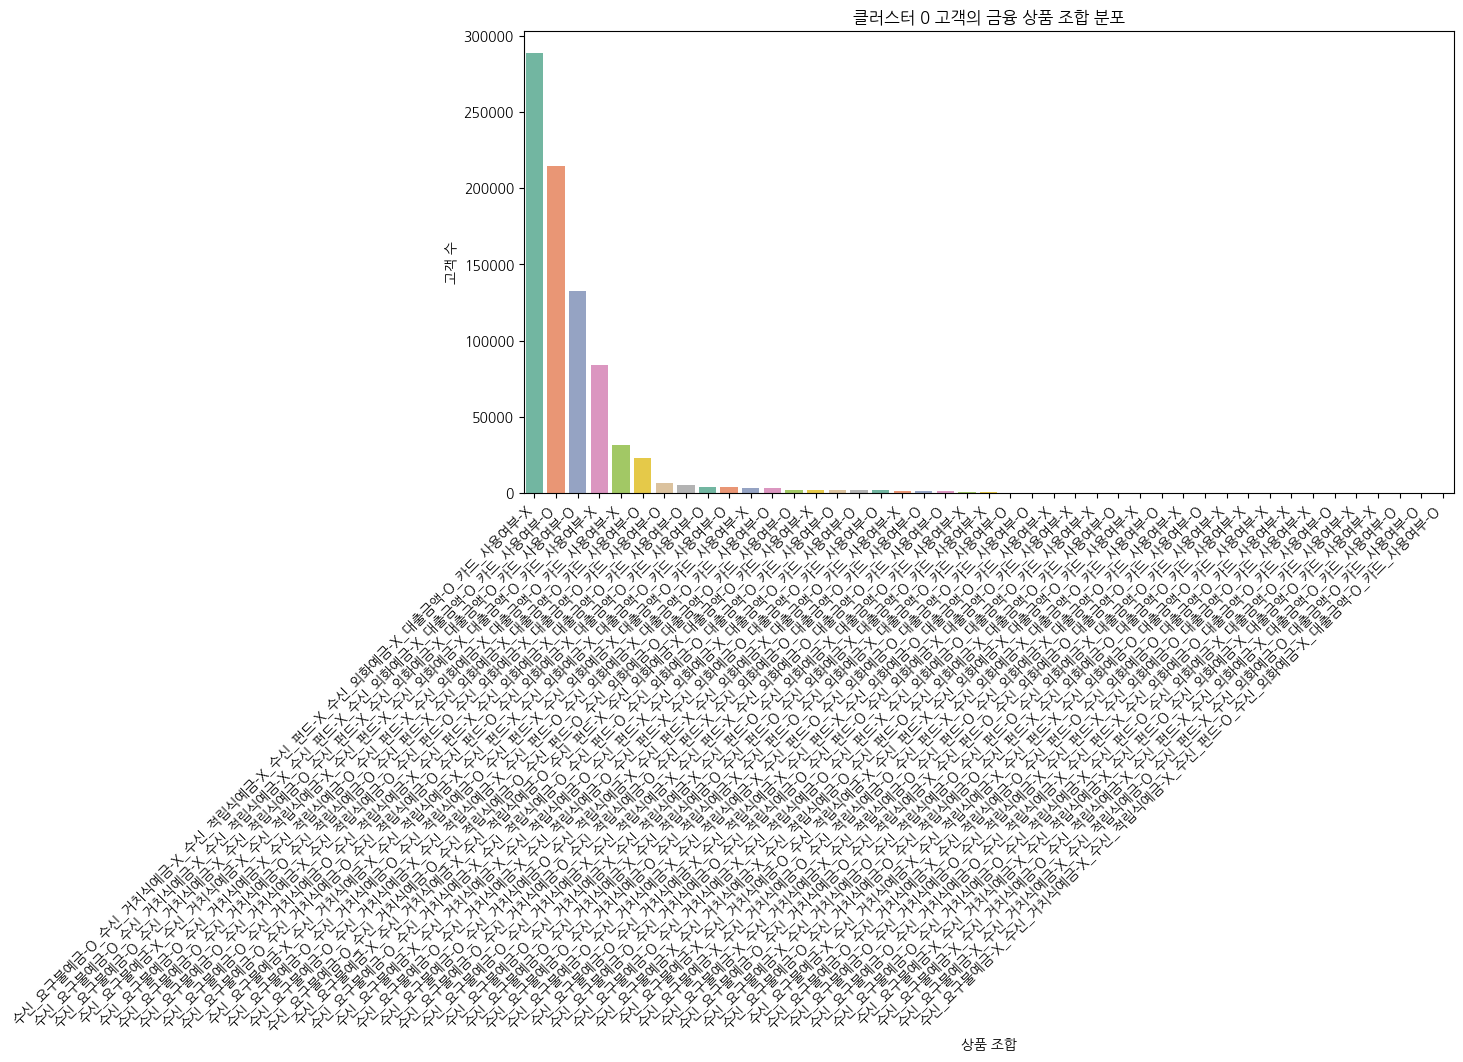

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(data=combo_summary_cluster_a, x="상품조합", y="고객수", palette="Set2")
plt.title("클러스터 0 고객의 금융 상품 조합 분포")
plt.xlabel("상품 조합")
plt.ylabel("고객 수")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 클러스터별 상위 6개 조합 가져오기

In [26]:
top_n = 6

In [27]:
top_combos_0 = combo_summary_cluster_a.head(top_n)
top_combos_1 = combo_summary_cluster_b.head(top_n)
top_combos_2 = combo_summary_cluster_c.head(top_n)
top_combos_3 = combo_summary_cluster_d.head(top_n)

In [28]:
# 조합을 간단하게 표현하는 함수
def simplify_combo(combo_str):
    parts = [p.replace("-O", "") for p in combo_str.split("_") if "-O" in p]
    return "+".join(parts) if parts else "없음"

In [29]:
top_combos_0 = top_combos_0.with_columns(pl.col("상품조합").map_elements(simplify_combo).alias("간단조합"))
top_combos_1 = top_combos_1.with_columns(pl.col("상품조합").map_elements(simplify_combo).alias("간단조합"))
top_combos_2 = top_combos_2.with_columns(pl.col("상품조합").map_elements(simplify_combo).alias("간단조합"))
top_combos_3 = top_combos_3.with_columns(pl.col("상품조합").map_elements(simplify_combo).alias("간단조합"))


In [30]:
top_combos_0

상품조합,고객수,간단조합
str,u32,str
"""수신_요구불예금-O_수신_거치식예금-X_수신_적립식예금…",288619,"""요구불예금+대출금액"""
"""수신_요구불예금-O_수신_거치식예금-X_수신_적립식예금…",214244,"""요구불예금+대출금액+사용여부"""
"""수신_요구불예금-O_수신_거치식예금-X_수신_적립식예금…",132494,"""요구불예금+적립식예금+대출금액+사용여부"""
"""수신_요구불예금-X_수신_거치식예금-X_수신_적립식예금…",84087,"""대출금액"""
"""수신_요구불예금-O_수신_거치식예금-X_수신_적립식예금…",31614,"""요구불예금+적립식예금+대출금액"""
"""수신_요구불예금-O_수신_거치식예금-O_수신_적립식예금…",22989,"""요구불예금+거치식예금+적립식예금+대출금액+사용여부"""


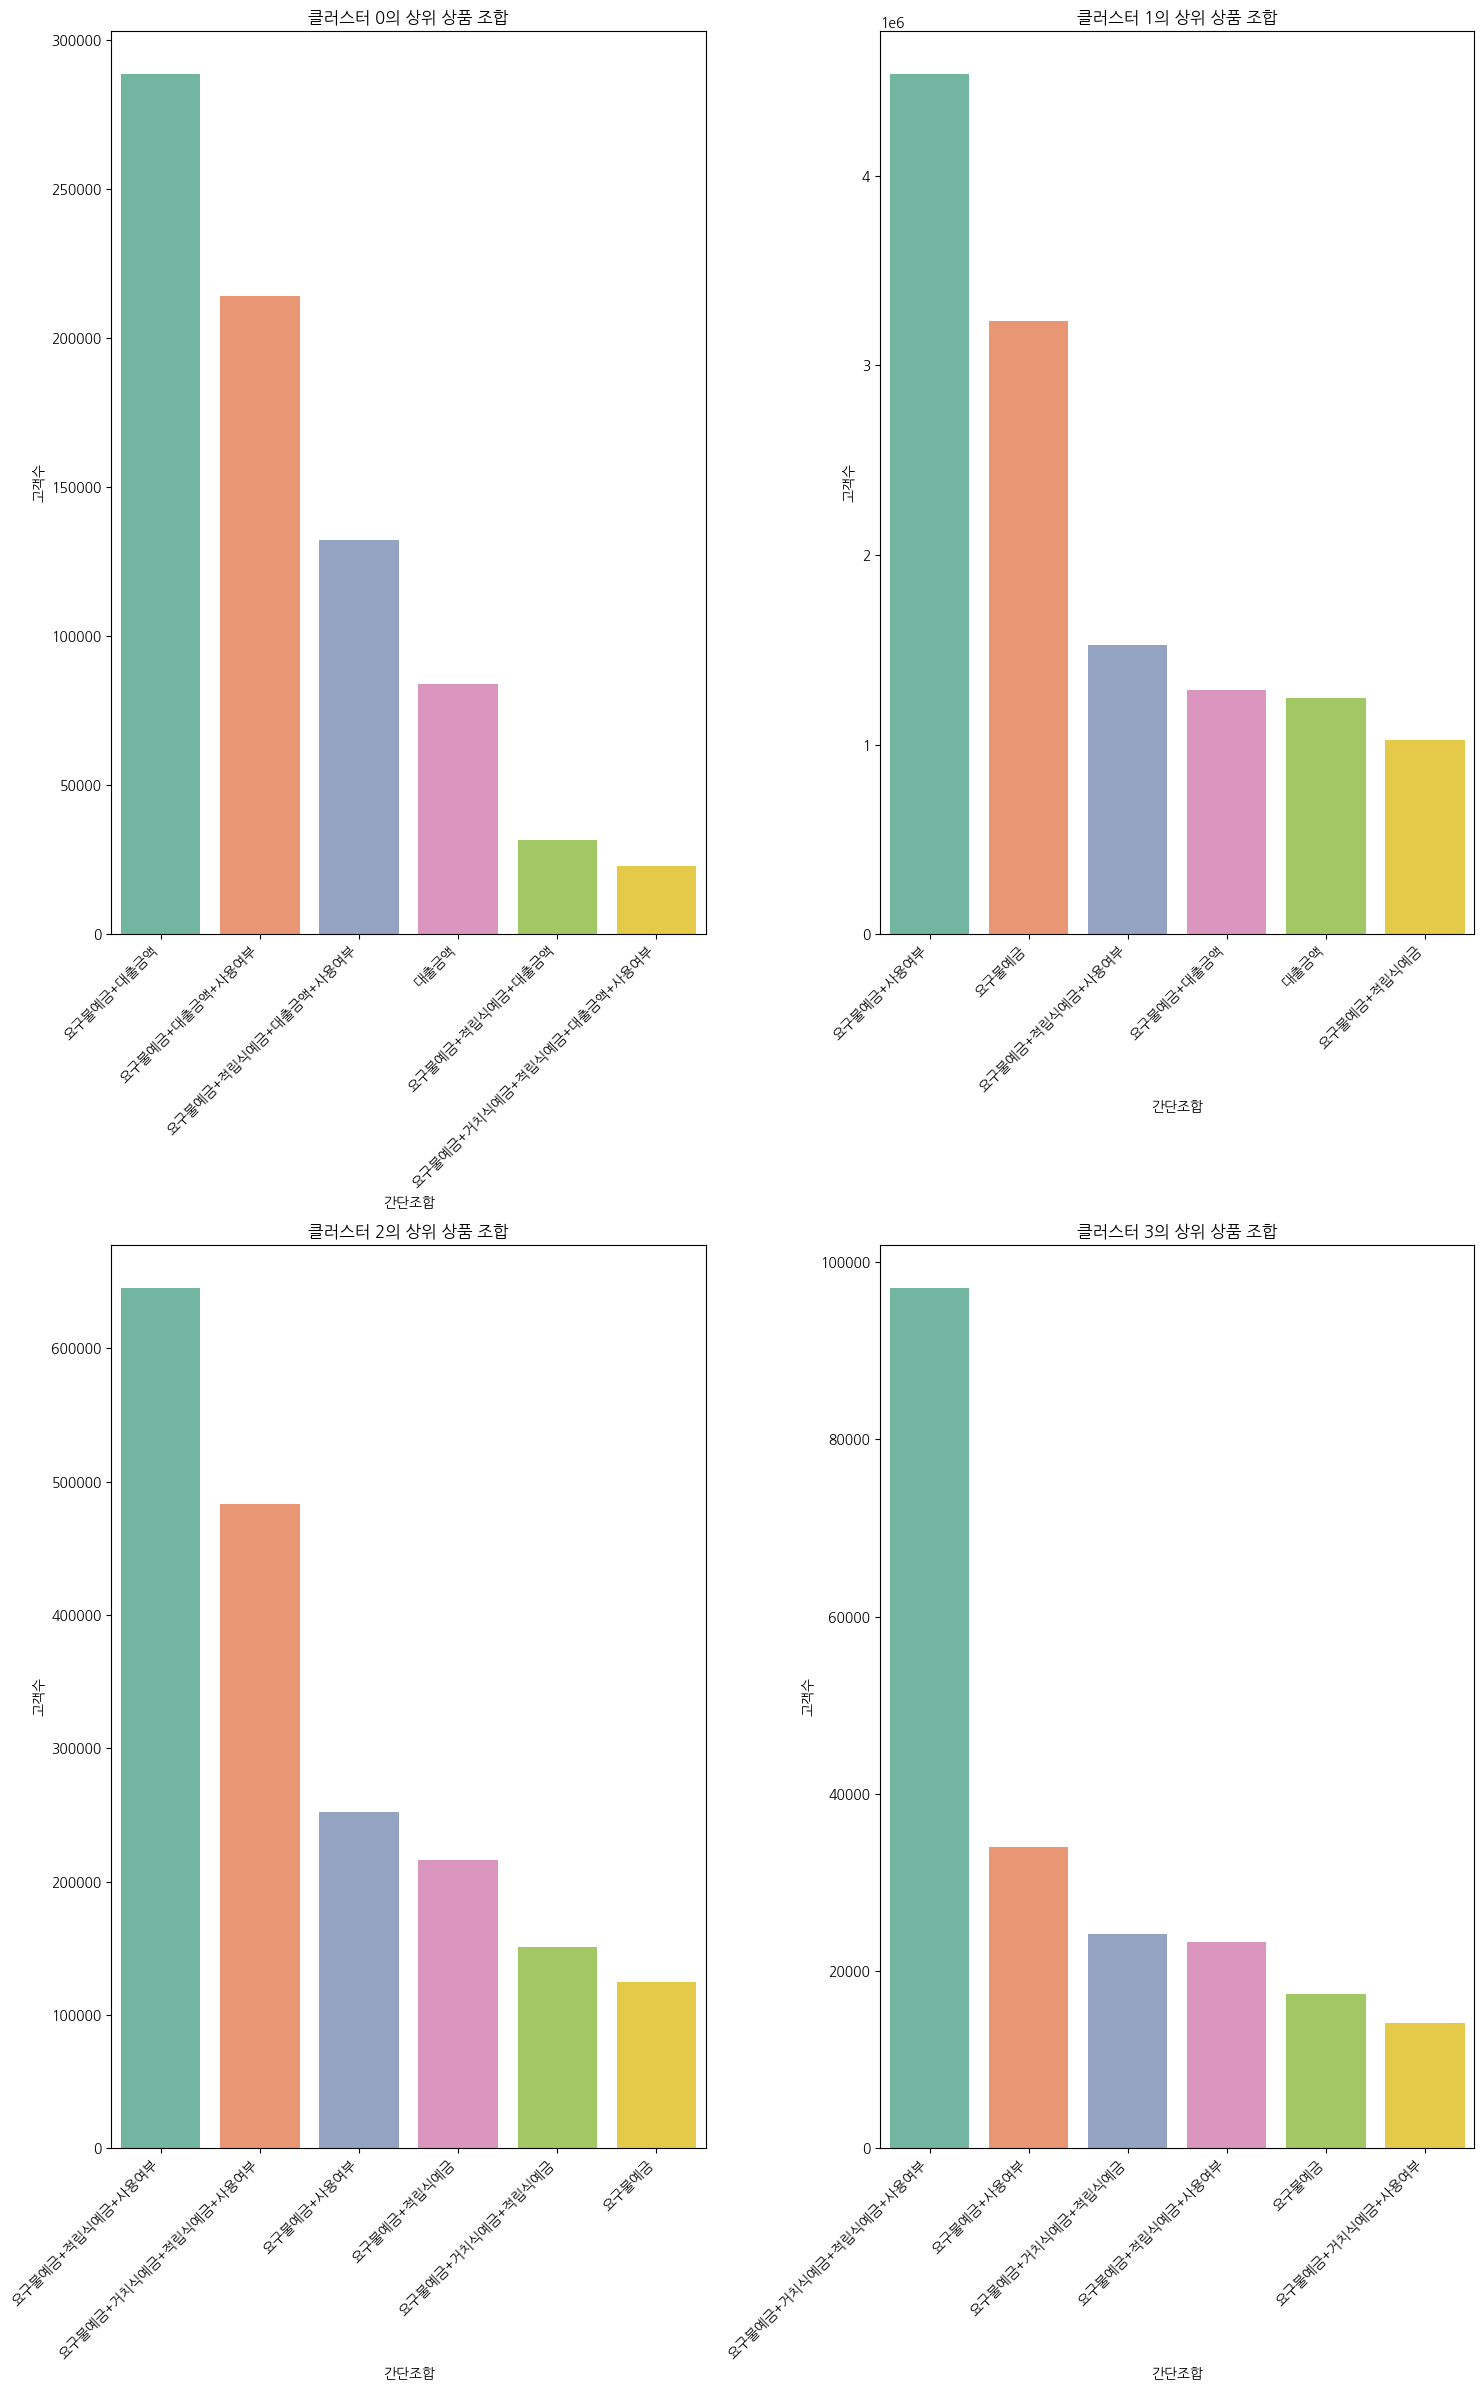

In [32]:
# 시각화
# 3x3 서브플롯 생성
fig, axes = plt.subplots(2, 2, figsize=(15, 24))  # 2x2 배치, 크기 조정
clusters = [top_combos_0, top_combos_1, top_combos_2, 
            top_combos_3]

titles = [f"클러스터 {i}의 상위 상품 조합" for i in range(9)]

for i, (df, ax, title) in enumerate(zip(clusters, axes.flatten(), titles)):
    # polars → pandas 변환
    top_combos_pd = df.select(["간단조합", "고객수"]).to_pandas()

    # Seaborn 막대 그래프
    sns.barplot(data=top_combos_pd, x="간단조합", y="고객수", palette="Set2", ax=ax)

    # 제목 및 설정
    ax.set_title(title, fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()  # 레이아웃 자동 조정
plt.show()

### 1. 클러스터별 조합별 고객 수 pivot table → Heatmap

In [35]:
# 각 데이터프레임에 클러스터 번호 컬럼 추가
# 클러스터별 데이터프레임을 리스트로 저장
combo_summary_clusters = [combo_summary_cluster_a, combo_summary_cluster_b, combo_summary_cluster_c, 
                          combo_summary_cluster_d]

# 클러스터 번호 컬럼 추가 및 리스트 생성
combo_dfs = []
for i, df in enumerate(combo_summary_clusters):
    df = df.with_columns([
        pl.lit(i).alias("클러스터"),  # 클러스터 번호 추가
        pl.col("상품조합").map_elements(simplify_combo).alias("간단조합")  # map_elements() 사용
    ])
    combo_dfs.append(df.select(["클러스터", "간단조합", "고객수"]))  # 필요한 컬럼 선택

In [36]:
combo_dfs[0].head(6)

클러스터,간단조합,고객수
i32,str,u32
0,"""요구불예금+대출금액""",288619
0,"""요구불예금+대출금액+사용여부""",214244
0,"""요구불예금+적립식예금+대출금액+사용여부""",132494
0,"""대출금액""",84087
0,"""요구불예금+적립식예금+대출금액""",31614
0,"""요구불예금+거치식예금+적립식예금+대출금액+사용여부""",22989


In [37]:
combo_dfs[1].head(6)

클러스터,간단조합,고객수
i32,str,u32
1,"""요구불예금+사용여부""",4535345
1,"""요구불예금""",3233168
1,"""요구불예금+적립식예금+사용여부""",1526334
1,"""요구불예금+대출금액""",1286097
1,"""대출금액""",1245855
1,"""요구불예금+적립식예금""",1024556


In [38]:
# 하나의 데이터프레임으로 병합
combo_all = pl.concat(combo_dfs)

# pandas로 변환 후 피벗 테이블 생성
combo_all_pd = combo_all.to_pandas()
pivot = combo_all_pd.pivot_table(index="간단조합", columns="클러스터", values="고객수", fill_value=0)

In [39]:
pivot

클러스터,0,1,2,3
간단조합,,,,
거치식예금,0.0,19520.0,26966.0,6023.0
거치식예금+대출금액,136.0,454.0,135.0,47.0
거치식예금+대출금액+사용여부,3.0,72.0,0.0,17.0
거치식예금+사용여부,0.0,1639.0,844.0,211.0
거치식예금+외화예금,0.0,0.0,36.0,24.0
...,...,...,...,...
펀드,0.0,30326.0,0.0,0.0
펀드+대출금액,6.0,222.0,0.0,0.0
펀드+대출금액+사용여부,1.0,0.0,0.0,0.0


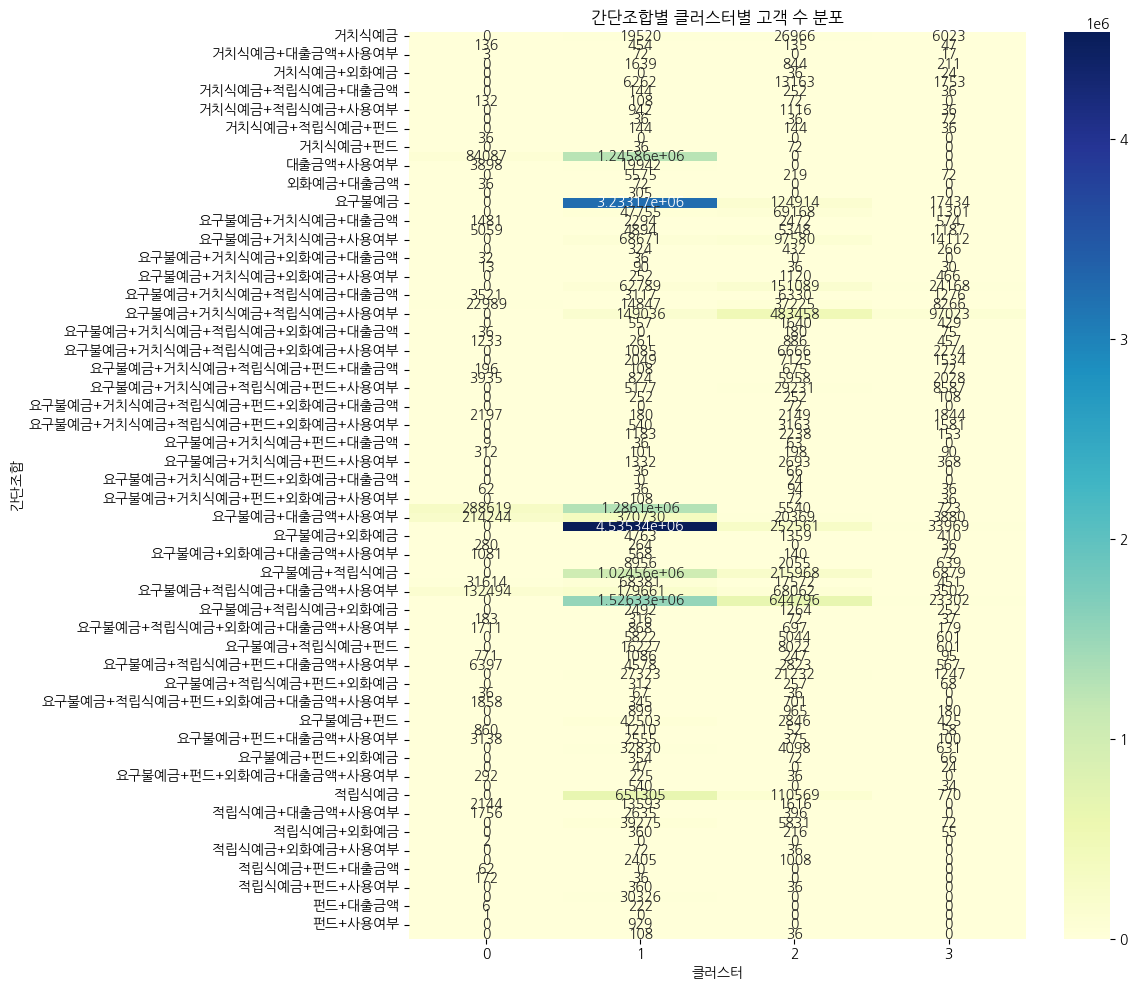

In [40]:
# Heatmap 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt="g")
plt.title("간단조합별 클러스터별 고객 수 분포")
plt.xlabel("클러스터")
plt.ylabel("간단조합")
plt.tight_layout()
plt.show()

### 2. 클러스터별 각 조합 비중 비교 (비율 기반)

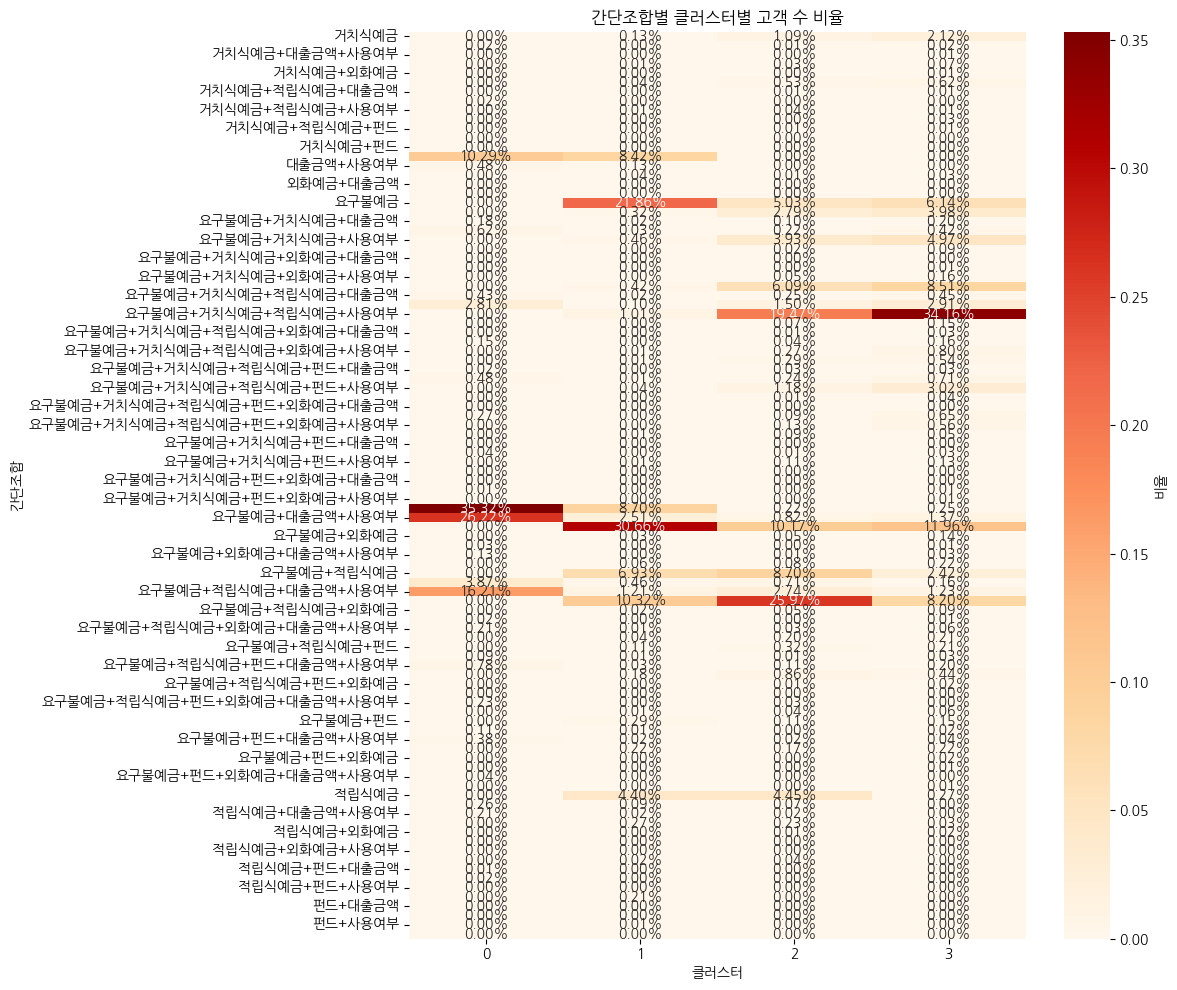

In [41]:
# 각 클러스터별로 전체 고객 수로 나눠서 비율 계산
pivot_ratio = pivot.divide(pivot.sum(axis=0), axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_ratio, cmap="OrRd", annot=True, fmt=".2%", cbar_kws={"label": "비율"})
plt.title("간단조합별 클러스터별 고객 수 비율")
plt.xlabel("클러스터")
plt.ylabel("간단조합")
plt.tight_layout()
plt.show()

In [42]:
pivot_ratio

클러스터,0,1,2,3
간단조합,,,,
거치식예금,0.000000,0.001320,0.010862,0.021206
거치식예금+대출금액,0.000166,0.000031,0.000054,0.000165
거치식예금+대출금액+사용여부,0.000004,0.000005,0.000000,0.000060
거치식예금+사용여부,0.000000,0.000111,0.000340,0.000743
거치식예금+외화예금,0.000000,0.000000,0.000015,0.000084
...,...,...,...,...
펀드,0.000000,0.002050,0.000000,0.000000
펀드+대출금액,0.000007,0.000015,0.000000,0.000000
펀드+대출금액+사용여부,0.000001,0.000000,0.000000,0.000000


In [65]:
# 해석 예시
# 클러스터 2에서 '요구불예금+거치식예금+적립식예금+카드' 조합이 고객의 55.38% 차지

In [43]:
# 인덱스를 컬럼으로 변환
pivot_ratio = pivot_ratio.reset_index()
# '간단조합'을 제외한 나머지 클러스터 컬럼에서 최대값 계산
pivot_ratio["최대값"] = pivot_ratio.drop(columns=["간단조합"]).max(axis=1)
# 최대값 기준 내림차순 정렬 후 "최대값" 컬럼 제거
pivot_ratio_sorted = pivot_ratio.sort_values(by="최대값", ascending=False).drop(columns=["최대값"])

In [44]:
pivot_ratio_sorted.head(10)

클러스터,간단조합,0,1,2,3
51,요구불예금+대출금액,0.353213,0.086956,0.002231,0.002546
30,요구불예금+거치식예금+적립식예금+사용여부,0.000000,0.010077,0.194733,0.341598
53,요구불예금+사용여부,0.000000,0.306647,0.101729,0.119598
52,요구불예금+대출금액+사용여부,0.262193,0.025066,0.008204,0.013661
61,요구불예금+적립식예금+사용여부,0.000000,0.103200,0.259718,0.082041
18,요구불예금,0.000000,0.218603,0.050314,0.061381
60,요구불예금+적립식예금+대출금액+사용여부,0.162147,0.012147,0.027415,0.012330
13,대출금액,0.102906,0.084236,0.000000,0.000000
58,요구불예금+적립식예금,0.000000,0.069273,0.086990,0.024220
27,요구불예금+거치식예금+적립식예금,0.000000,0.004245,0.060857,0.085091


### 3. 특정 조합 기준으로 클러스터 특이성 확인

In [75]:
# pivot.loc["요구불+대출"].sort_values(ascending=False).plot(kind="bar")
# plt.title("요구불+대출 조합의 클러스터별 분포")
# plt.ylabel("고객 수")
# plt.xlabel("클러스터")
# plt.show()

# 2. 클러스터별 연관 규칙 분석 -> 어떤 상품을 가진 고객이 다른 상품도 가질 확률
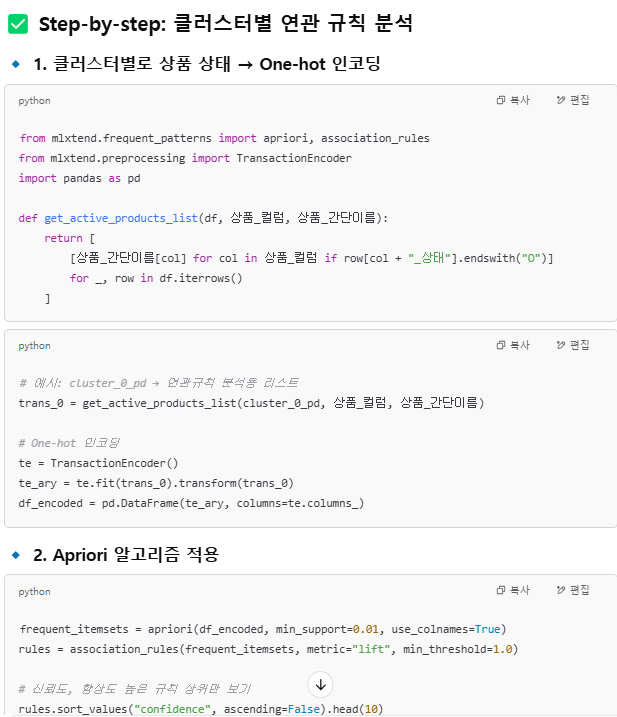
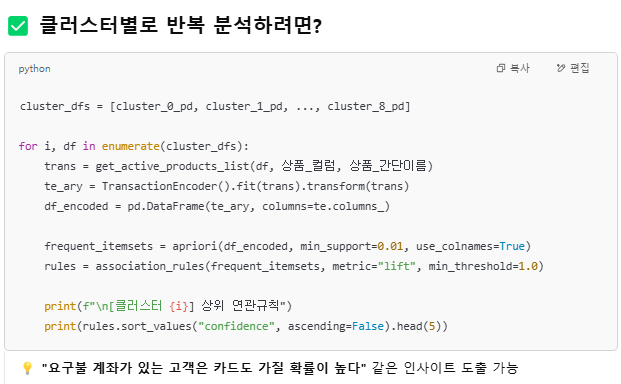

# 3. 상품 흐름 분석 -> 고객이 상품을 이용한 순서를 기반으로 흐름 분석
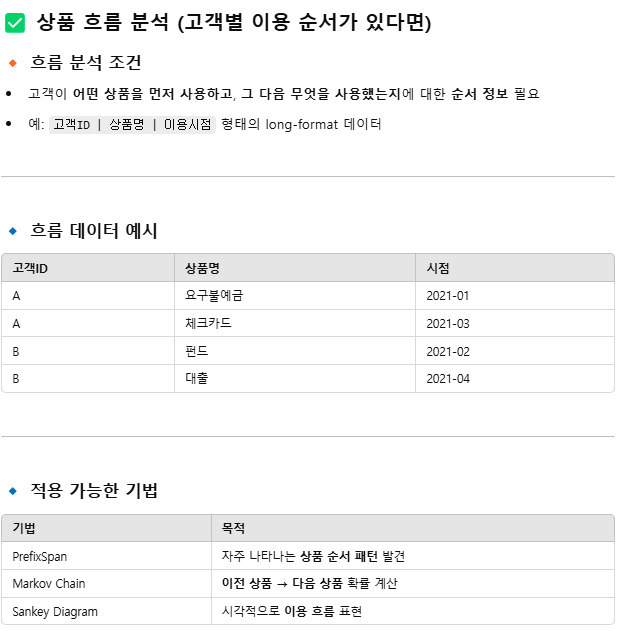
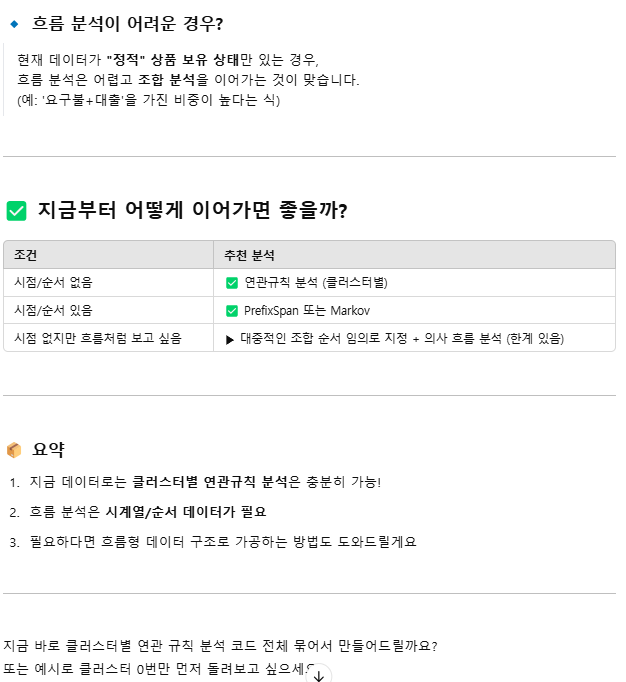